In [1]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import ast
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('mel_features_dataset.csv')

In [3]:
X = df['Mel_Features'].values
y = df['Ragas'].values

In [ ]:
print("Shape of X before reshape:", X.shape)
print("Shape of y before encode:", y.shape)

Shape of X before reshape: (174,)
Shape of y before encode: (174,)


In [4]:
le=LabelEncoder()
ti=le.fit_transform(y)
y_mel=to_categorical(ti)

In [5]:
X_train,X_test,y_train,y_test=train_test_split(X,y_mel,test_size=0.2,random_state=127)

In [6]:
num_classes = len(y_mel[0])
print(num_classes)

9


In [7]:
#X_train_flat = np.array([x.flatten() for x in X_train])
y_train_numerical = np.argmax(y_train, axis=1)
y_test_numerical = np.argmax(y_test, axis=1)
y_train_encoded = to_categorical(y_train_numerical, num_classes=num_classes)
y_test_encoded = to_categorical(y_test_numerical, num_classes=num_classes)

In [8]:
print(X_train[0])

[[-49.23179  -40.900173 -35.22286  ... -80.       -80.       -80.      ]
 [-49.131256 -37.39643  -26.980406 ... -80.       -80.       -80.      ]
 [-50.548172 -39.183334 -25.958849 ... -80.       -80.       -80.      ]
 ...
 [-50.58346  -31.450312 -25.43192  ... -80.       -80.       -80.      ]
 [-50.48502  -32.110584 -25.729435 ... -80.       -80.       -80.      ]
 [-43.868637 -31.801788 -25.15377  ... -80.       -80.       -80.      ]]


In [9]:
print(type(X_train))
print(X_train.shape)
print(type(X_train[0]))

<class 'numpy.ndarray'>
(139,)
<class 'str'>


In [10]:
def remove_nan_from_list_np(data_list):
    temp_array = np.array(data_list)
    return temp_array[~np.isnan(temp_array)].tolist()

In [11]:
import io

def cleaned_string_array(arr, cleaned_list):
  for i, str_array in enumerate(arr):
    try:
      cleaned_str_array = str_array.strip('[]')
      cleaned_str_array = ' '.join(cleaned_str_array.split())
      sio = io.StringIO(cleaned_str_array)
      numerical_array = np.genfromtxt(sio, dtype=float)
      cleaned_list.append(numerical_array)
    except Exception as e:
        print(f"Error processing sample{e}")

In [12]:
loaded_X_train = []
loaded_X_test = []

cleaned_string_array(X_train, loaded_X_train)
cleaned_string_array(X_test, loaded_X_test)

In [13]:
s_Train = pd.Series(loaded_X_train)
s_Test = pd.Series(loaded_X_test)
cleaned_X_train = s_Train.apply(remove_nan_from_list_np)
cleaned_X_test = s_Test.apply(remove_nan_from_list_np)

In [14]:
print(type(cleaned_X_train))
print(cleaned_X_train.shape)
print(cleaned_X_train.head())

<class 'pandas.core.series.Series'>
(139,)
0    [-49.23179, -40.900173, -35.22286, -80.0, -80....
1    [-73.1736, -65.56986, -46.832676, -80.0, -80.0...
2    [-33.193417, -38.61211, -47.274662, -65.94535,...
3    [-26.856775, -29.381496, -30.761852, -69.10777...
4    [-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -80...
dtype: object


In [17]:
#Padding the spectrograms
padded_X_train_list = []
for spec_list in cleaned_X_train:
    if len(spec_list) < 31:
        padded_spec = spec_list + [-80.0] * (31 - len(spec_list))
    else:
        padded_spec = spec_list[:31]
    padded_X_train_list.append(padded_spec)

In [18]:
cleaned_X_train_np = np.array(padded_X_train_list, dtype=np.float32)

In [19]:
print(f"Shape of NumPy array after padding: {cleaned_X_train_np.shape}")

Shape of NumPy array after padding: (139, 31)


In [20]:
cleaned_X_train_reshaped = cleaned_X_train_np.reshape(
    cleaned_X_train_np.shape[0], 31, 1
)
print(f"Final reshaped array shape for 1D CNN: {cleaned_X_train_reshaped.shape}")

Final reshaped array shape for 1D CNN: (139, 31, 1)


In [21]:
model_mel = Sequential()
model_mel.add(Conv1D(32, 3, activation='relu', input_shape=(31, 1)))
model_mel.add(MaxPooling1D(pool_size=2))
model_mel.add(Conv1D(64, 3, activation='relu'))
model_mel.add(Flatten())
model_mel.add(Dense(128, activation='relu'))
model_mel.add(Dense(num_classes, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model_mel.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_mel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 29, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 14, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 12, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,929 (413.79 KB)

 Trainable params: 105,929 (413.79 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
print(y_train_encoded.shape)
print(y_test_encoded.shape)

(139, 9)
(35, 9)


In [24]:
#Padding the test data spectrograms
padded_X_test_list = []
for spec_list in cleaned_X_test:
    if len(spec_list) < 31:
        padded_spec = spec_list + [-80.0] * (31 - len(spec_list))
    else:
        padded_spec = spec_list[:31]
    padded_X_test_list.append(padded_spec)

In [25]:
cleaned_X_test_np = np.array(padded_X_test_list, dtype=np.float32)
print(f"Shape of NumPy array after padding: {cleaned_X_test_np.shape}")

Shape of NumPy array after padding: (35, 31)


In [26]:
cleaned_X_test_reshaped = cleaned_X_test_np.reshape(
    cleaned_X_test_np.shape[0], 31, 1
)
print(f"Final reshaped array shape for 1D CNN: {cleaned_X_test_reshaped.shape}")

Final reshaped array shape for 1D CNN: (35, 31, 1)


In [27]:
history_mel = model_mel.fit(cleaned_X_train_reshaped, y_train_encoded, epochs=30, batch_size=32, validation_data=(cleaned_X_test_reshaped, y_test_encoded))

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.1692 - loss: 14.6293 - val_accuracy: 0.2000 - val_loss: 6.5008
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1622 - loss: 5.2502 - val_accuracy: 0.0571 - val_loss: 5.0371
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0443 - loss: 4.4885 - val_accuracy: 0.1714 - val_loss: 2.7573
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2226 - loss: 2.7168 - val_accuracy: 0.1429 - val_loss: 3.7539
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3316 - loss: 2.4478 - val_accuracy: 0.1143 - val_loss: 2.6929
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2745 - loss: 2.0836 - val_accuracy: 0.2286 - val_loss: 2.5005
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2999 - loss: 1.8612 - val_accuracy: 0.1429 - val_loss: 2.6726
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3366 - loss: 1.8232 - val_accuracy: 0.2857 - val_loss: 2.2519

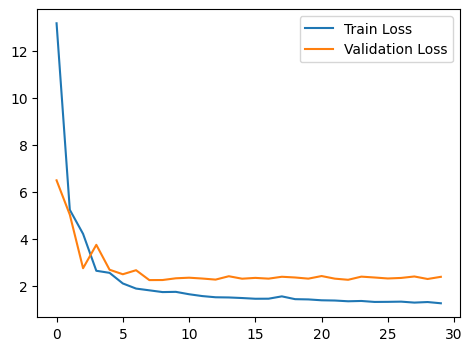

In [28]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_mel.history['loss'], label='Train Loss')
plt.plot(history_mel.history['val_loss'], label='Validation Loss')
plt.legend()

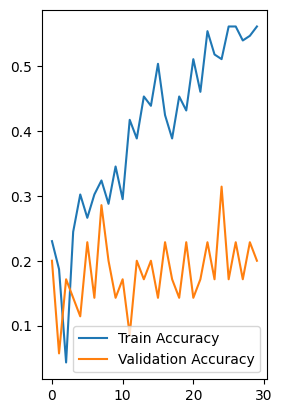

In [29]:
plt.subplot(1, 2, 2)
plt.plot(history_mel.history['accuracy'], label='Train Accuracy')
plt.plot(history_mel.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()